In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# load data

In [2]:
df = pd.read_csv('RB8888.csv').set_index('timeindex')
# df.index = pd.to_datetime(df.index)
price = df['close']
volume = df['volume']

df.head()

,open,close,high,low,volume
timeindex,,,,,
2017-01-03 09:01:00,2885.447,2885.754,2895.206,2878.535,64796.0
2017-01-03 09:02:00,2886.598,2890.491,2894.599,2884.694,23852.0
2017-01-03 09:03:00,2891.837,2953.977,2985.279,2890.007,130530.0
2017-01-03 09:04:00,2953.214,2947.205,2958.096,2939.512,66118.0
2017-01-03 09:05:00,2946.176,2957.059,2965.828,2946.176,69890.0


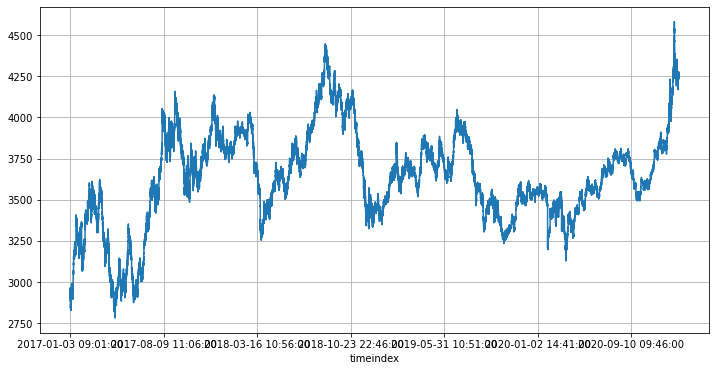

In [3]:
plt.figure(figsize=(12,6))
df.close.plot()
plt.grid(True)

# calculate indicators

In [4]:
def sma(price, lookback=10, return_multiple=True):
    sma_value = price.rolling(window=lookback).mean()
    sma_trend = (price / sma_value - 1).fillna(0)
    if return_multiple:
        return sma_trend, sma_value
    else:
        return sma_trend

def bollinger_bands(price, lookback=10, return_multiple=True):
    rolling_std = price.rolling(window=lookback).std()
    mid_line = price.rolling(window=lookback).mean()
    upper_band = mid_line + 2 * rolling_std
    lower_band = mid_line - 2 * rolling_std
    bbp = ((price - lower_band) / (upper_band - lower_band) - 0.5).fillna(0)
    bbp[bbp==np.inf] = 0
    bbp[bbp==-np.inf] = 0
    if return_multiple:
        return bbp, mid_line, upper_band, lower_band
    else:
        return bbp

def momentum(price, lookback=10):
    return price.pct_change(lookback).fillna(0)
    
def macd(price, lookback1=12, lookback2=26, lookback3=9, return_multiple=True):
    ma1 = price.ewm(span=lookback1, adjust=False).mean()
    ma2 = price.ewm(span=lookback2, adjust=False).mean()
    dif = ma1 - ma2
    dea = dif.ewm(span=lookback3, adjust=False).mean().fillna(0)
    macd = dif - dea
    if return_multiple:
        return macd, ma1, ma2
    else:
        return macd
    
def obv(price, volume, lookback=10):
    dif = price.diff()
    vols = volume.copy()
    vols[dif < 0] = -vols[dif < 0]
    vols[dif == 0] = 0
    obv = vols.ewm(span=lookback, adjust=False).mean()
    return normalize(obv, lookback).fillna(0)
    
def normalize(signal, window):
    return signal.rolling(window=window).mean() / signal.rolling(window=window).std()


def plot_sma_trend(price, sma_signal, sma_trend_signal):
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex='all', figsize=(12, 9))
    x = sma_signal.index
    ax1.plot(price.values, label="Price (Adj Close)")
    ax1.plot(sma_signal.values, label="SMA")
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax1.set_title('SMA')

    ax2.plot(sma_trend_signal.values, label="Price/SMA-1")
    ax2.grid(True)
    ax2.legend(loc='lower right')
    ax2.set_title('SMA Trend')
    plt.xlabel('Date')
    plt.ylabel('Indicator')
    plt.savefig("sma_plot.png")

def plot_bb(price, bbp, mid_line, upper_band, lower_band):
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex='all', figsize=(12, 9))
    x = price.index
    ax1.plot(price.values, label="Price (Adj Close)")
    ax1.plot(mid_line.values, label="Mid Line")
    ax1.plot(upper_band.values, label="Upper Band")
    ax1.plot(lower_band.values, label="Lower Band")
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax1.set_title('Bollinger Bands')

    ax2.plot(bbp.values, label="Bollinger Bands %")
    ax2.grid(True)
    ax2.legend(loc='lower right')
    ax2.set_title('Bollinger Bands %')
    plt.xlabel('Date')
    plt.ylabel('Indicator')
    plt.savefig("bb_plot.png")

def plot_momentum(price, momentum_signal):
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex='all', figsize=(12, 9))
    x = price.index
    ax1.plot(price.values, label="Price (Adj Close)")
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax1.set_title('Price')

    ax2.plot(momentum_signal.values, label="Momentum")
    ax2.grid(True)
    ax2.legend(loc='lower right')
    ax2.set_title('Momentum')
    plt.xlabel('Date')
    plt.ylabel('Indicator')
    plt.savefig("momentum_plot.png")
    

def plot_macd(price, macd_signal, ema1, ema2):
    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex='all', figsize=(12, 9))
    x = price.index
    ax1.plot(price.values, label="Price (Adj Close)")
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax1.set_title('Price')

    ax2.plot(ema1.values, label="EMA1")
    ax2.plot(ema2.values, label="EMA2")
    ax2.grid(True)
    ax2.legend(loc='lower right')
    ax2.set_title('EMA')
    plt.xlabel('Date')
    plt.ylabel('EMA')

    ax3.plot(macd_signal.values, label="MACD")
    ax3.grid(True)
    ax3.legend(loc='lower right')
    ax3.set_title('MACD')
    plt.xlabel('Date')
    plt.ylabel('Indicator')
    plt.savefig("macd_plot.png")

def plot_obv(price, volume, obv_signal):
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex='all', figsize=(12, 9))
    x = price.index
    ax1.plot(price.values, label="Price (Adj Close)")
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax1.set_title('Price')
    
    ax2.plot(obv_signal.values, label="OBV")
    ax2.grid(True)
    ax2.legend(loc='lower right')
    ax2.set_title('OBV')
    plt.xlabel('Date')
    plt.ylabel('Indicator')
    plt.savefig("obv_plot.png")

def get_action_signals(signal, upper_limit, lower_limit):
    action = pd.Series(index=signal.index)
    action[(signal.shift(1) < upper_limit) & (signal >= upper_limit)] = 1
    action[(signal.shift(1) > lower_limit) & (signal <= lower_limit)] = -1
    return action.fillna(0)

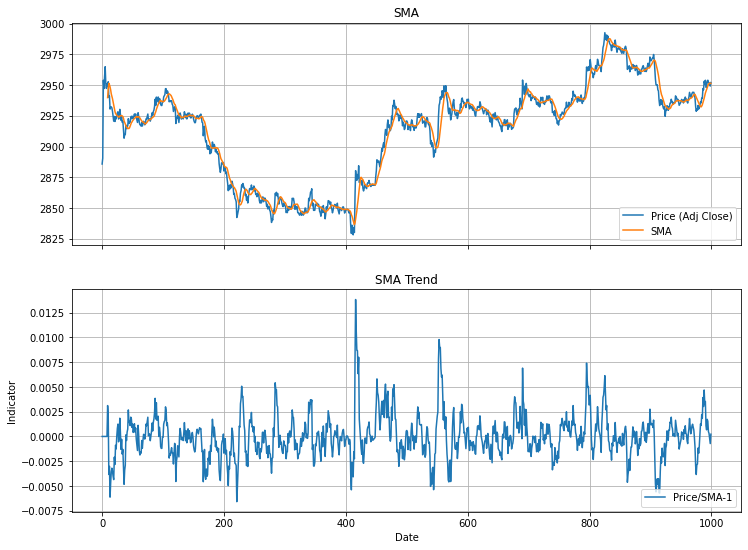

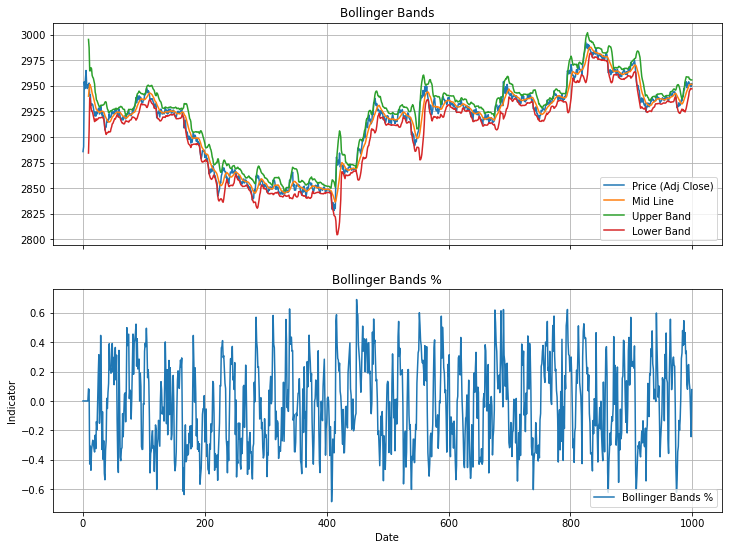

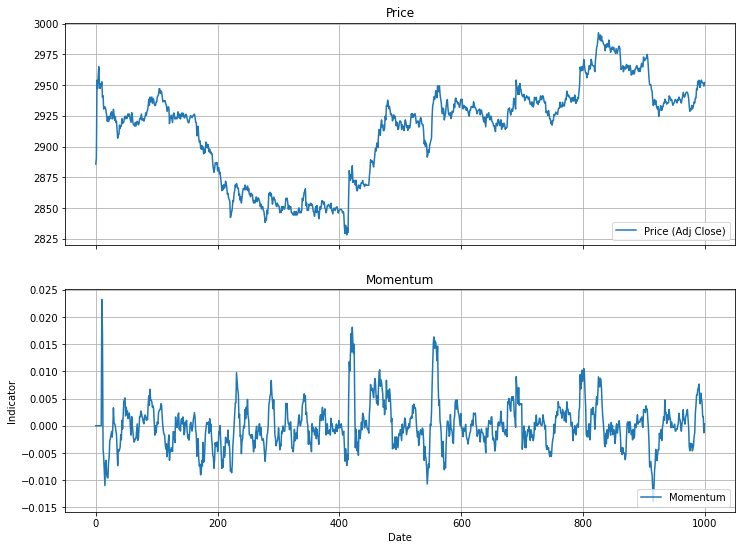

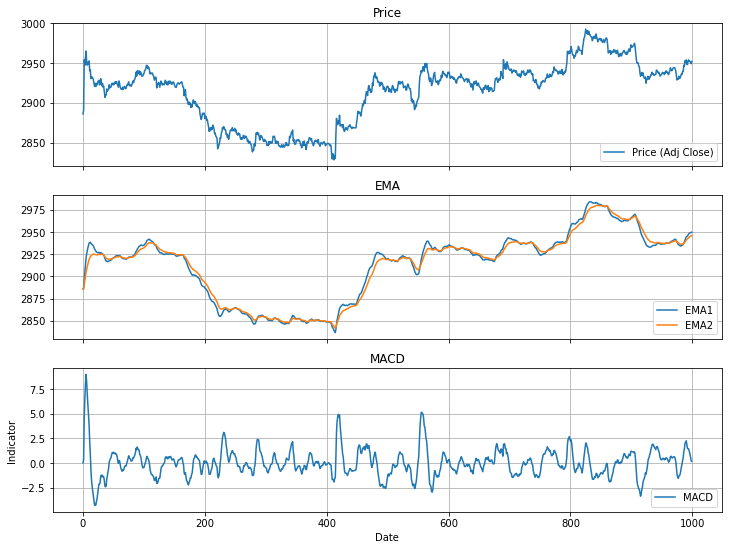

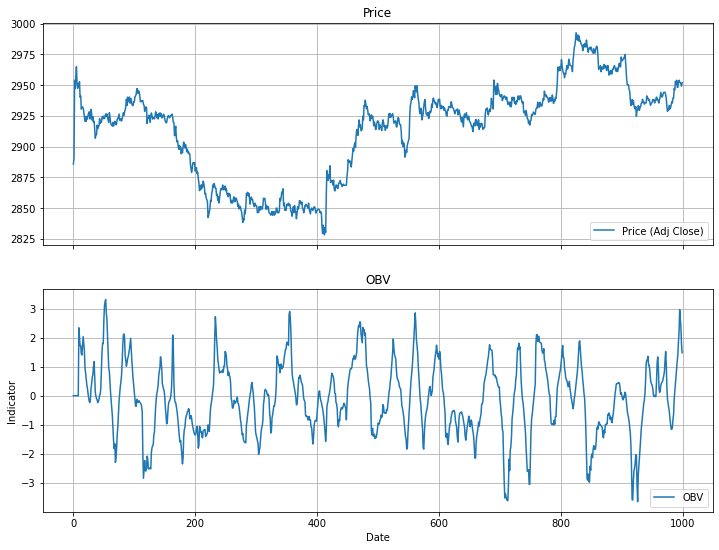

In [5]:
show_length = 1000

price_ = price.iloc[:show_length]
volume_ = volume.iloc[:show_length]

# indicator 1: sma trend
sma_trend_signal, sma_signal = sma(price_, lookback=10)
plot_sma_trend(price_, sma_signal, sma_trend_signal)

# indicator 2: bollinger band
bbp, mid_line, upper_band, lower_band = bollinger_bands(price_, lookback=10)
plot_bb(price_, bbp, mid_line, upper_band, lower_band)

# indicator 3: momentum
momentum_signal = momentum(price_, lookback=10)
plot_momentum(price_, momentum_signal)

# indicator 4: macd
macd_signal, ema1, ema2 = macd(price_, lookback1=12, lookback2=26, lookback3=9)
plot_macd(price_, macd_signal, ema1, ema2)

# indicator 5: obv
obv_signal = obv(price_, volume_, lookback=10)
plot_obv(price_, volume_, obv_signal)


## calculate indicator for all data

In [6]:
sma_trend_signal, sma_signal = sma(price, lookback=10)
bbp, mid_line, upper_band, lower_band = bollinger_bands(price, lookback=10)
momentum_signal = momentum(price, lookback=10)
macd_signal, ema1, ema2 = macd(price, lookback1=12, lookback2=26, lookback3=9)
obv_signal = obv(price, volume, lookback=10)


## calculate action signals

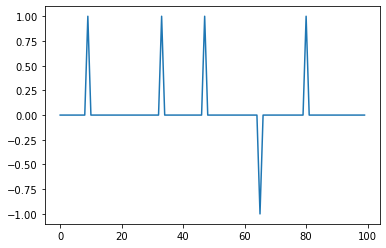

In [7]:
sma_trend_action = get_action_signals(sma_trend_signal, upper_limit=0.02, lower_limit=-0.02)
bb_action = get_action_signals(bbp, upper_limit=0.3, lower_limit=-0.3)
momentum_action = get_action_signals(momentum_signal, upper_limit=0.1, lower_limit=-0.1)
macd_action = get_action_signals(macd_signal, upper_limit=0.5, lower_limit=-0.5)
obv_action = get_action_signals(obv_signal, upper_limit=1, lower_limit=-1)

plt.plot(obv_action.values[:100])

# Calulation holding strategy

In [80]:
def sample_to_daily( df, mode, tradingdays):
    df.index = tradingdays
    if mode == 'end':
        df_daily = df.groupby(level=0).last()
    elif mode == 'sum':
        df_daily = df.groupby(level=0).sum()
    else:
        raise KeyError('Unkonw sample method.')
    return df_daily

def get_bkt_result(action, slippage=0):
    action[action==0] = np.nan
    position = action.fillna(method='ffill').fillna(method='bfill')
    
    pnl = (position * price.diff().shift(-1)).fillna(0) - position.diff().abs().fillna(0) * price * slippage

    bkt = pd.DataFrame()
    bkt['price'] = price
    bkt['position'] = position
    bkt['pnl'] = pnl
    bkt['cum pnl'] = pnl.cumsum()
    bkt.index = pd.to_datetime(bkt.index)
    bkt['date'] = bkt.index.date

    bkt_daily = pd.DataFrame()
    bkt_daily['price'] = sample_to_daily(bkt['price'], 'end', bkt['date'])
    bkt_daily['position'] = sample_to_daily(bkt['position'], 'end', bkt['date'])
    bkt_daily['pnl'] = sample_to_daily(bkt['pnl'], 'sum', bkt['date'])
    bkt_daily['cum pnl'] = bkt_daily['pnl'].cumsum()

    return bkt_daily

def sharpe_ratio(pnl):
    return 16 * pnl.mean() / pnl.std()

## OBV

<AxesSubplot:xlabel='date'>

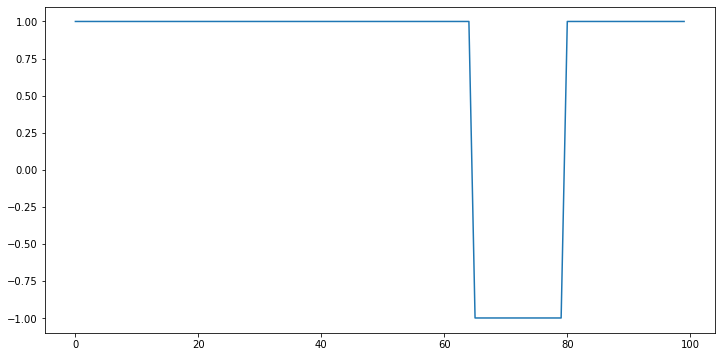

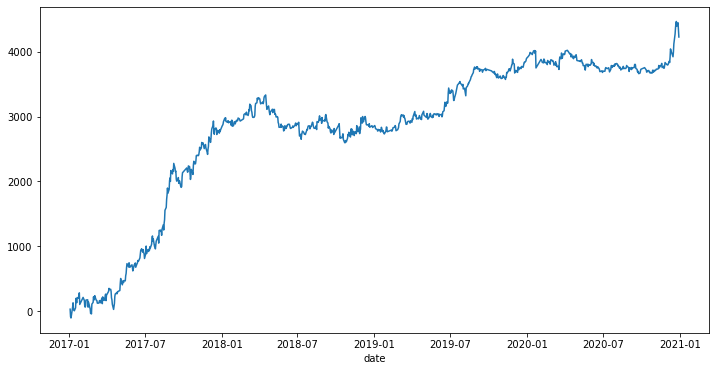

In [9]:
obv_action[obv_action==0] = np.nan
position = obv_action.fillna(method='ffill').fillna(method='bfill')
bkt_obv = get_bkt_result(obv_action)

plt.figure(figsize=(12,6))
plt.plot(position.values[:100])

plt.figure(figsize=(12,6))
bkt_obv['cum pnl'].plot()

## SMA

<AxesSubplot:xlabel='date'>

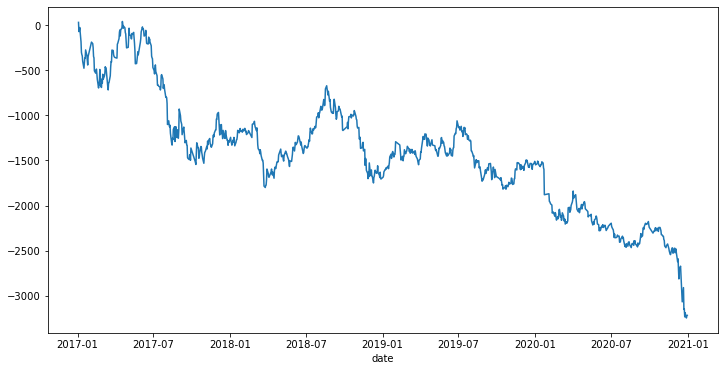

In [10]:
bkt_sma = get_bkt_result(sma_trend_action)

plt.figure(figsize=(12,6))
bkt_sma['cum pnl'].plot()

## Bollinger Bands

<AxesSubplot:xlabel='date'>

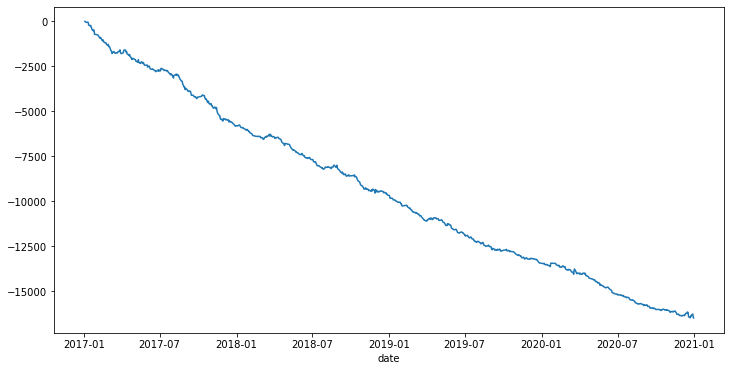

In [11]:
bkt_bb = get_bkt_result(bb_action, slippage=0.0000)

plt.figure(figsize=(12,6))
bkt_bb['cum pnl'].plot()

<AxesSubplot:xlabel='date'>

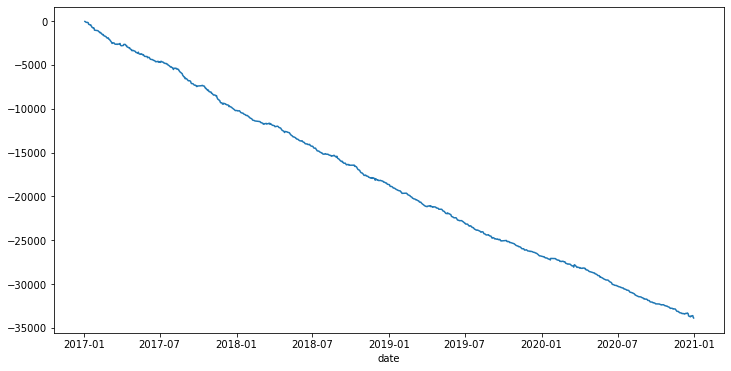

In [12]:
bkt_bb = get_bkt_result(bb_action, slippage=0.0001)

plt.figure(figsize=(12,6))
bkt_bb['cum pnl'].plot()

# Prediction with models

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [66]:
y = price.pct_change(100).fillna(0)
    
x1 = sma_trend_signal
x2 = bbp
x3 = obv_signal
X = pd.concat([x1, x2, x3, x1*x2, x2*x3, x1*x3, x1**2, x2**2, x3**2], axis=1)


## overfitting

### linear regression

In [94]:
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)

y_hat = reg.predict(X)
y_signal = pd.Series(y_hat, index=price.index)
np.std(y_hat)

0.11720437030558628
[ 1.52334798e+00 -1.62037141e-03  1.40334734e-03 -4.15429718e-01
 -1.72478702e-04  7.64673188e-02  6.64178080e+00  1.44135587e-03
  1.27580585e-05]


0.002604541803113188

Sharpe Ratio: 0.73
Sharpe Ratio: 0.62
Sharpe Ratio: 0.51
Sharpe Ratio: 0.18


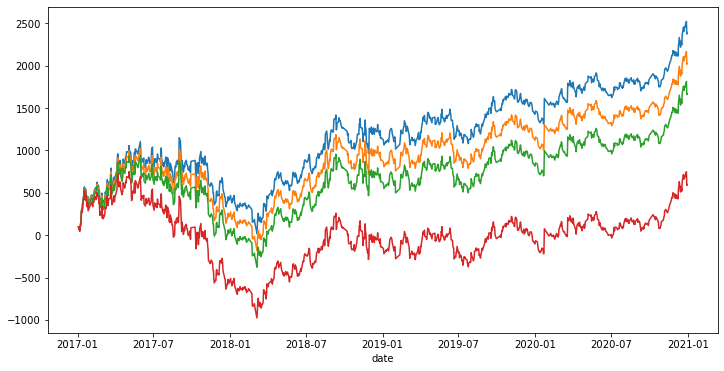

In [95]:
std_multiple = 3
y_action = get_action_signals(y_signal, upper_limit=std_multiple*np.std(y_hat), lower_limit=-std_multiple*np.std(y_hat))

plt.figure(figsize=(12,6))

for slippage in [0, 0.0001, 0.0002, 0.0005]:
    bkt_y = get_bkt_result(y_action, slippage=slippage)    
    bkt_y['cum pnl'].plot()
    print(f'Sharpe Ratio: {sharpe_ratio(bkt_y["pnl"]):.2f}')

### decision tree regression

In [96]:
reg = DecisionTreeRegressor().fit(X, y)
y_hat = reg.predict(X)
y_signal = pd.Series(y_hat, index=price.index)
np.std(y_hat)

0.007607773861284406

Sharpe Ratio: 0.82
Sharpe Ratio: 0.80
Sharpe Ratio: 0.78
Sharpe Ratio: 0.72


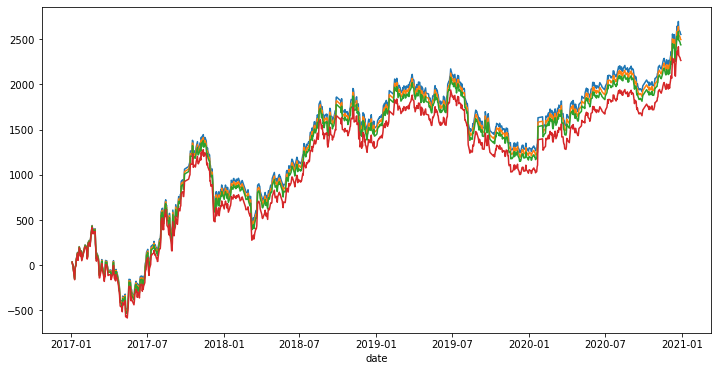

In [97]:
std_multiple = 3
y_action = get_action_signals(y_signal, upper_limit=std_multiple*np.std(y_hat), lower_limit=-std_multiple*np.std(y_hat))

plt.figure(figsize=(12,6))

for slippage in [0, 0.0001, 0.0002, 0.0005]:
    bkt_y = get_bkt_result(y_action, slippage=slippage)    
    bkt_y['cum pnl'].plot()
    print(f'Sharpe Ratio: {sharpe_ratio(bkt_y["pnl"]):.2f}')